In [1]:
from __future__ import absolute_import, division, print_function
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

from collections import defaultdict
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as img

## Download data

In [2]:
tf.keras.utils.get_file(
    "food-101.tar.gz",
    "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz",
    cache_subdir="/Users/udyansachdev/Downloads/ML_Final/content",
    extract=True,
    archive_format="tar",
    cache_dir=None,
)

4996278331/4996278331 ━━━━━━━━━━━━━━━━━━━━ 1307s 0us/step


'/Users/udyansachdev/Downloads/ML_Final/content/food-101.tar.gz'

### Plotting Image

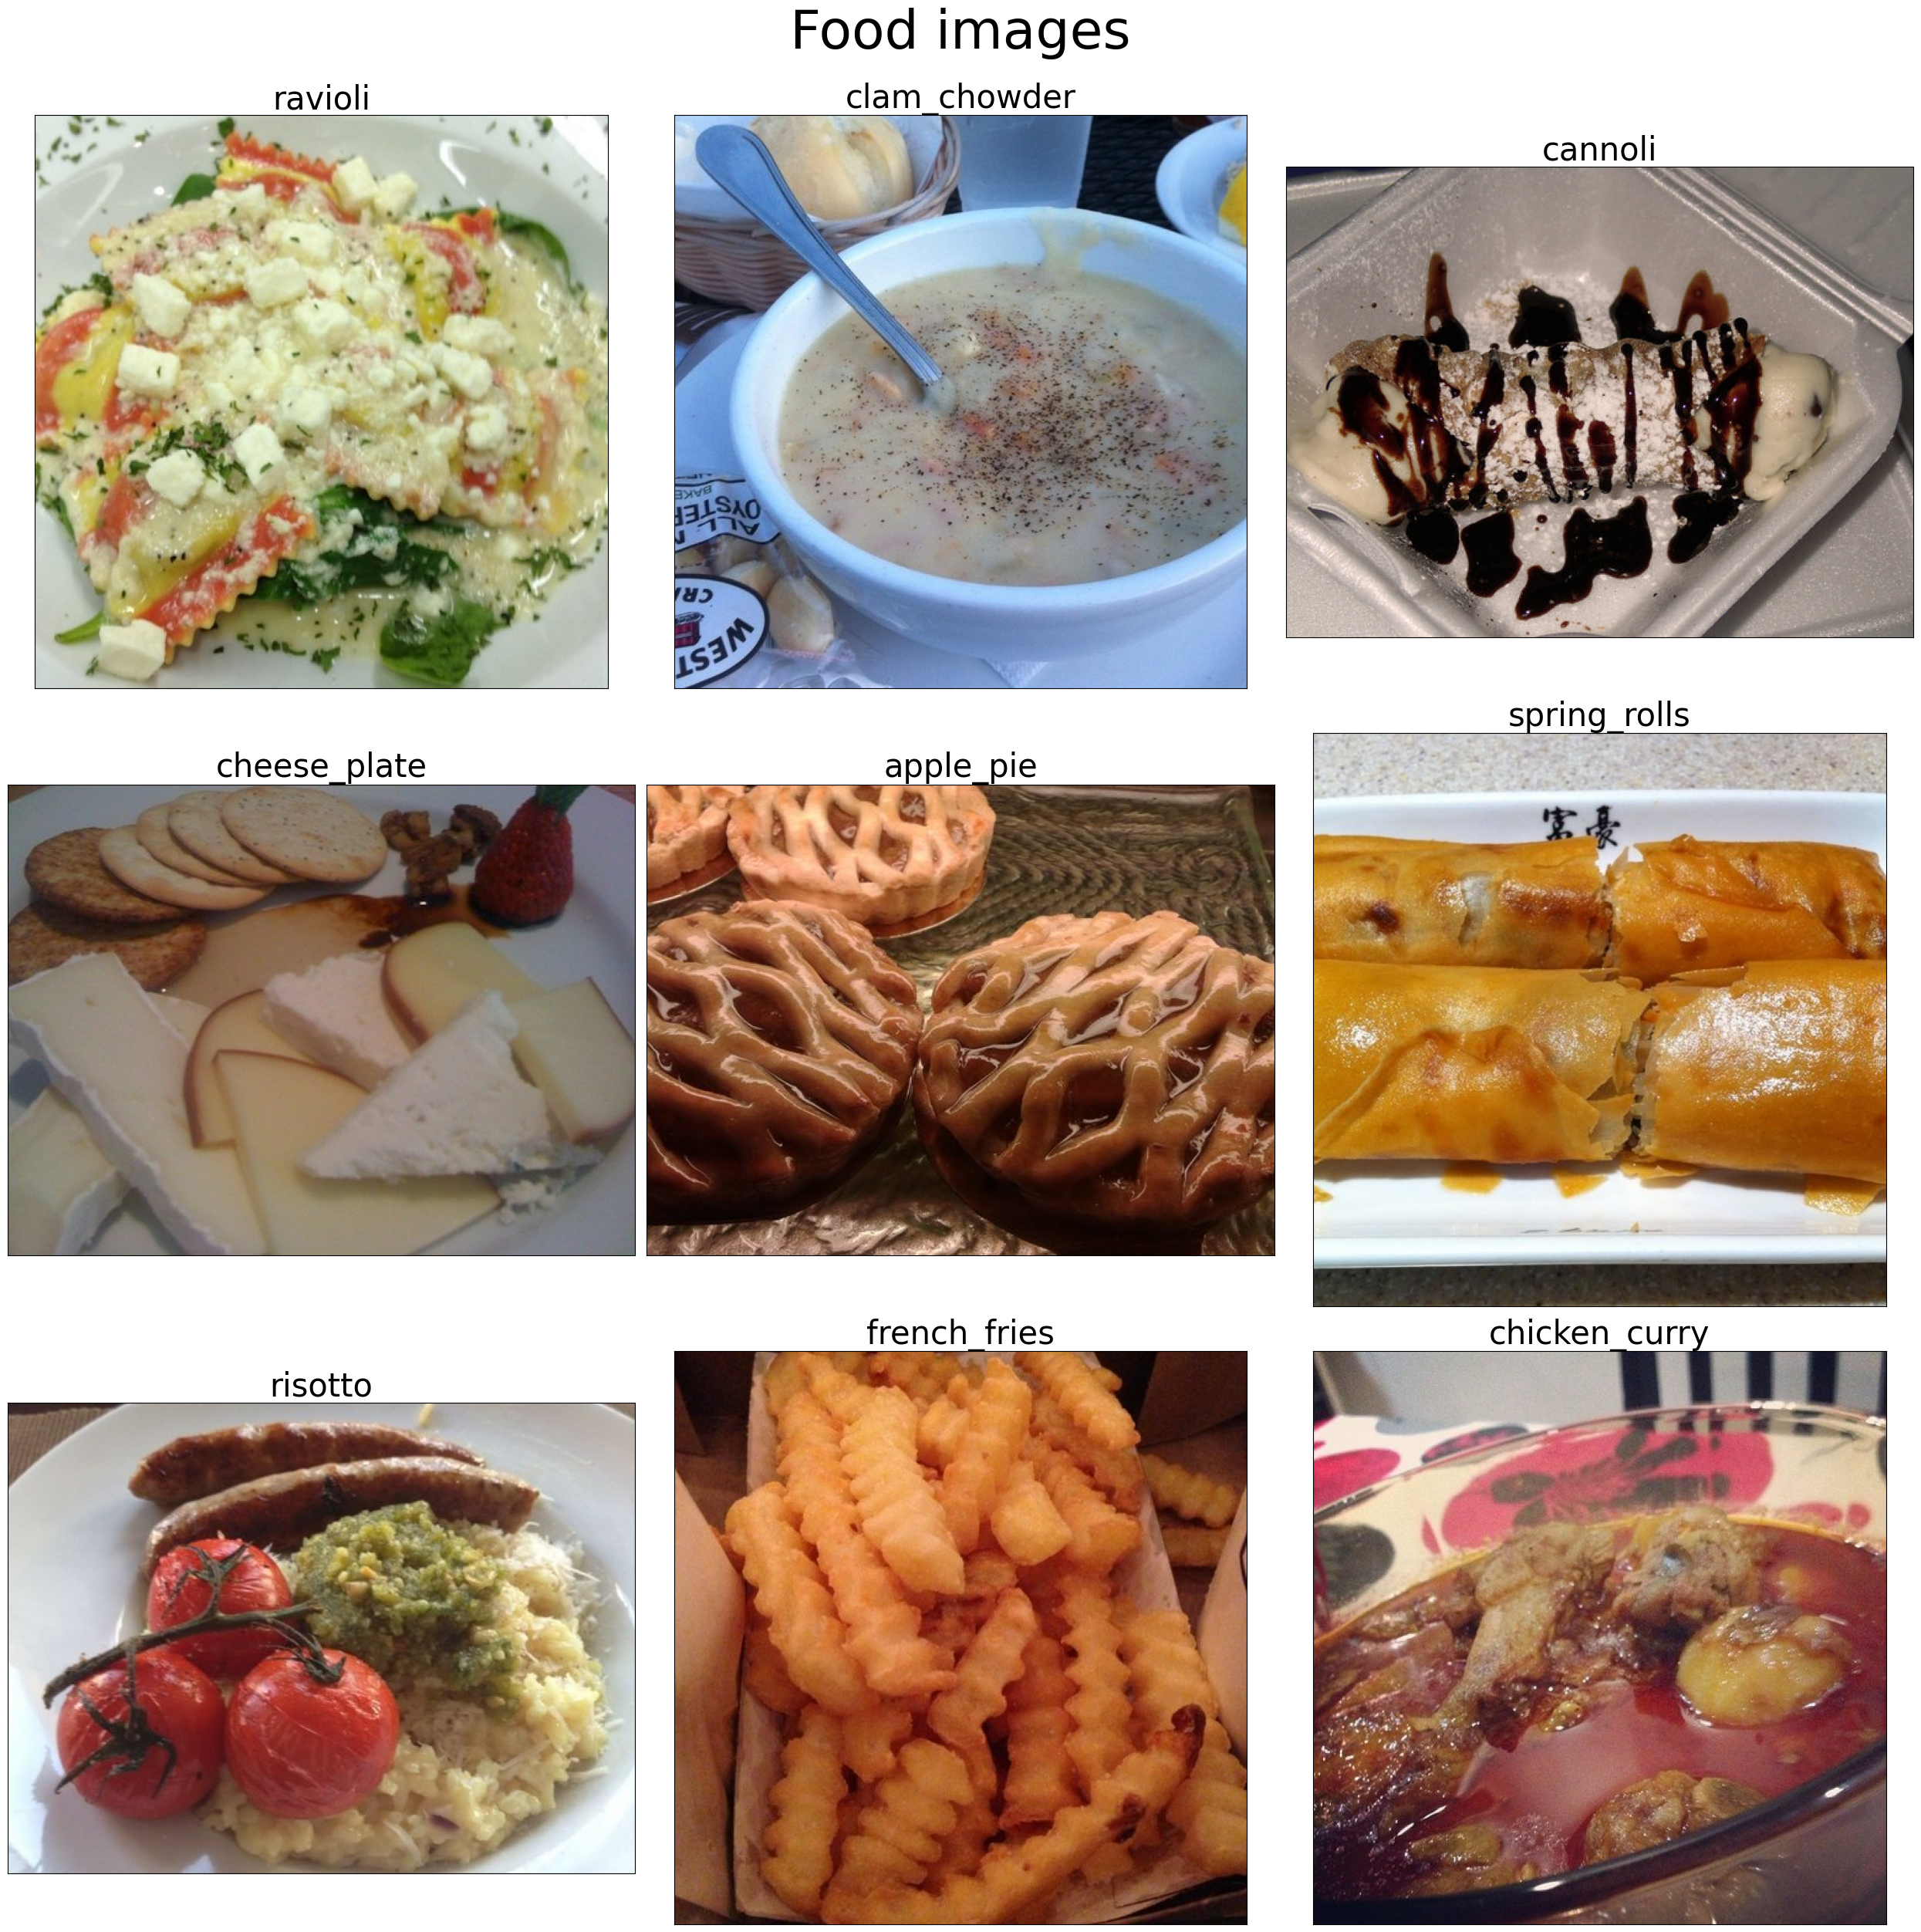

In [2]:
# Visualize the data

fig, ax = plt.subplots(3, 3, figsize=(25, 25))
fig.suptitle("Food images", y=1, fontsize=50)

food_names = sorted(os.listdir("content/food-101/images/"))

for i in range(3):
    for j in range(3):
        food_list = food_names[random.randrange(0, 101, 2)]

        food_selected_images = os.listdir(
            os.path.join("content/food-101/images/", food_list)
        )
        food_selected_random = np.random.choice(food_selected_images)
        img = plt.imread(
            os.path.join("content/food-101/images/", food_list, food_selected_random)
        )
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_list, fontsize=30)

# Remove axis ticks and labels
for axis in ax.flatten():
    axis.set_xticks([])
    axis.set_yticks([])

# Adjust layout
plt.tight_layout()

# Split the image data into train and test using train.txt and test.txt

In [4]:
def split_data(source, dest, file_path):
    classes_images = defaultdict(list)
    with open(file_path, "r") as txt:
        paths = [line.strip() for line in txt.readlines()]
        for p in paths:
            food, image = p.split("/")
            classes_images[food].append(image + ".jpg")

    for food, images in classes_images.items():
        food_src = os.path.join(source, food)
        food_dest = os.path.join(dest, food)
        os.makedirs(food_dest, exist_ok=True)
        for image in images:
            src_path = os.path.join(food_src, image)
            dest_path = os.path.join(food_dest, image)
            shutil.copy2(src_path, dest_path)
    print("Splitting Completed")

In [5]:
split_data(
    "content/food-101/images",
    "content/food-101/train",
    "content/food-101/meta/train.txt",
)

Splitting Completed


In [6]:
split_data(
    "content/food-101/images", "content/food-101/test", "content/food-101/meta/test.txt"
)

Splitting Completed


In [3]:
training_count = sum(len(files) for _, _, files in os.walk("content/food-101/train"))
print("Total number of images in training data:", training_count)

Total number of images in training data: 75750


In [4]:
testing_count = sum(len(files) for _, _, files in os.walk("content/food-101/test"))
print("Total number of images in testing data:", testing_count)

Total number of images in testing data: 25250


## Working with 11 classes

In [8]:
def subset_data(source_dir, destination_dir, food_subset):
    # Loop through each food folder and copy it to the destination directory
    for food_folder in food_subset:
        # Construct source and destination paths
        source_folder = os.path.join(source_dir, food_folder)
        destination_folder = os.path.join(destination_dir, food_folder)

        # Copy the folder
        shutil.copytree(source_folder, destination_folder)
        print(f"Copied {food_folder} folder to {destination_dir}")

In [9]:
food_subset = [
    "tiramisu",
    "tuna_tartare",
    "beet_salad",
    "fish_and_chips",
    "pancakes",
    "caesar_salad",
    "garlic_bread",
    "carrot_cake",
    "chocolate_mousse",
    "hot_dog",
    "steak",
]

### Training Subset

In [10]:
subset_data("content/food-101/train", "content/food-101/train_subset", food_subset)

Copied tiramisu folder to content/food-101/train_subset
Copied tuna_tartare folder to content/food-101/train_subset
Copied beet_salad folder to content/food-101/train_subset
Copied fish_and_chips folder to content/food-101/train_subset
Copied pancakes folder to content/food-101/train_subset
Copied caesar_salad folder to content/food-101/train_subset
Copied garlic_bread folder to content/food-101/train_subset
Copied carrot_cake folder to content/food-101/train_subset
Copied chocolate_mousse folder to content/food-101/train_subset
Copied hot_dog folder to content/food-101/train_subset
Copied steak folder to content/food-101/train_subset


### Testing Subset

In [11]:
subset_data("content/food-101/test", "content/food-101/test_subset", food_subset)

Copied tiramisu folder to content/food-101/test_subset
Copied tuna_tartare folder to content/food-101/test_subset
Copied beet_salad folder to content/food-101/test_subset
Copied fish_and_chips folder to content/food-101/test_subset
Copied pancakes folder to content/food-101/test_subset
Copied caesar_salad folder to content/food-101/test_subset
Copied garlic_bread folder to content/food-101/test_subset
Copied carrot_cake folder to content/food-101/test_subset
Copied chocolate_mousse folder to content/food-101/test_subset
Copied hot_dog folder to content/food-101/test_subset
Copied steak folder to content/food-101/test_subset


In [3]:
training_subset_count = sum(
    len(files) for _, _, files in os.walk("content/food-101/train_subset")
)
print("Total number of images in training data:", training_subset_count)

Total number of images in training data: 8251


In [4]:
testing_subset_count = sum(
    len(files) for _, _, files in os.walk("content/food-101/test_subset")
)
print("Total number of images in testing data:", testing_subset_count)

Total number of images in testing data: 2751


## Using Inception model


In [5]:
def model_func(n_classes, num_epochs, nb_train_samples, nb_validation_samples):
    K.clear_session()

    bestmodel_path = "bestmodel_food101_efficientnet1.keras"
    trainedmodel_path = "trainedmodel_food101_efficientnet1.keras"
    history_path = "history_food101_efficientnet1.log"

    training_data = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
    )

    testing_data = ImageDataGenerator(preprocessing_function=preprocess_input)

    training_data_generator = training_data.flow_from_directory(
        "content/food-101/train_subset",
        target_size=(300, 300),
        batch_size=8,
        class_mode="categorical",
    )

    validation_data_generator = testing_data.flow_from_directory(
        "content/food-101/test_subset",
        target_size=(300, 300),
        batch_size=8,
        class_mode="categorical",
    )

    eff_net = EfficientNetV2L(weights="imagenet", include_top=False)
    fc = eff_net.output
    fc = GlobalAveragePooling2D()(fc)
    fc = Dense(128, activation="relu")(fc)
    fc = Dropout(0.2)(fc)

    predictions = Dense(
        n_classes, kernel_regularizer=regularizers.l2(0.005), activation="softmax"
    )(fc)

    model = Model(inputs=eff_net.input, outputs=predictions)
    model.compile(
        optimizer=SGD(learning_rate=0.0001, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    checkpoint = ModelCheckpoint(
        filepath=bestmodel_path, verbose=1, save_best_only=True
    )
    csv_logger = CSVLogger(history_path)

    history = model.fit(
        training_data_generator,
        steps_per_epoch=nb_train_samples // 8,
        validation_data=validation_data_generator,
        validation_steps=nb_validation_samples // 8,
        epochs=num_epochs,
        verbose=1,
        callbacks=[csv_logger, checkpoint],
    )

    model.save(trainedmodel_path)

    return history, training_data_generator.class_indices

In [6]:
# Train the model with data from 3 classes
n_classes = 11
epochs = 5
nb_train_samples = training_subset_count
nb_validation_samples = testing_subset_count

history, class_map_3 = model_func(
    n_classes, epochs, nb_train_samples, nb_validation_samples
)
print(class_map_3)

Python(28919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.1107 - loss: 2.5016 
Epoch 1: val_loss improved from inf to 2.38338, saving model to bestmodel_food101_efficientnet1.keras
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 38855s 38s/step - accuracy: 0.1107 - loss: 2.5016 - val_accuracy: 0.2387 - val_loss: 2.3834
Epoch 2/5
   1/1031 ━━━━━━━━━━━━━━━━━━━━ 4:18:16 15s/step - accuracy: 0.0000e+00 - loss: 2.4687

2024-04-13 13:13:30.841298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-04-13 13:13:32.332258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_loss improved from 2.38338 to 1.19651, saving model to bestmodel_food101_efficientnet1.keras
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.0000e+00 - loss: 1.2356 - val_accuracy: 0.1667 - val_loss: 1.1965
Epoch 3/5
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2650 - loss: 2.3514 
Epoch 3: val_loss did not improve from 1.19651
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 16871s 16s/step - accuracy: 0.2651 - loss: 2.3514 - val_accuracy: 0.5536 - val_loss: 2.0108
Epoch 4/5
   1/1031 ━━━━━━━━━━━━━━━━━━━━ 4:52:26 17s/step - accuracy: 0.5000 - loss: 2.0842

2024-04-13 17:55:02.967467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-13 17:55:04.593839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 1.19651 to 1.13198, saving model to bestmodel_food101_efficientnet1.keras
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.5000 - loss: 1.0431 - val_accuracy: 0.3333 - val_loss: 1.1320
Epoch 5/5
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.4490 - loss: 1.9832 
Epoch 5: val_loss did not improve from 1.13198
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 22246s 22s/step - accuracy: 0.4491 - loss: 1.9831 - val_accuracy: 0.6811 - val_loss: 1.4891
{'beet_salad': 0, 'caesar_salad': 1, 'carrot_cake': 2, 'chocolate_mousse': 3, 'fish_and_chips': 4, 'garlic_bread': 5, 'hot_dog': 6, 'pancakes': 7, 'steak': 8, 'tiramisu': 9, 'tuna_tartare': 10}


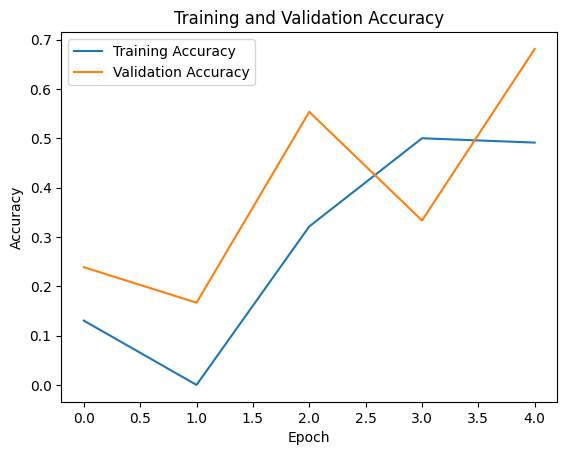

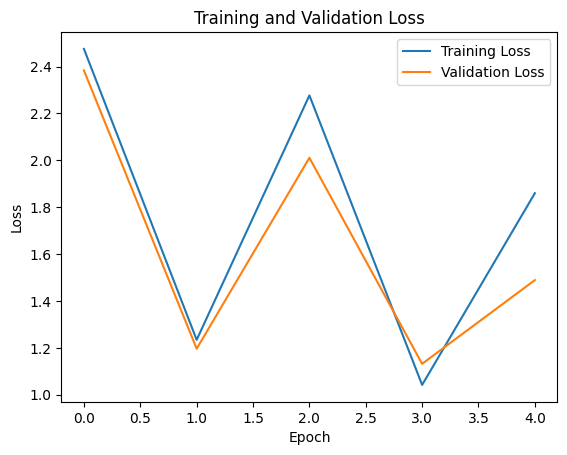

In [7]:
def plot_training_history(history, title):
    plt.title(title)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.show()


def plot_loss_history(history, title):
    plt.title(title)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.show()


plot_training_history(history, "Training and Validation Accuracy")
plot_loss_history(history, "Training and Validation Loss")

## Predicting classes for new images from internet using the best trained model

In [ ]:
model_best = load_model("bestmodel.keras", compile=False)

In [ ]:
def predict_class(model, images, show=True):
    for img in images:
        img = image.load_img(img, target_size=(299, 299))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)

        pred = model.predict(img)
        index = np.argmax(pred)
        food_subset.sort()
        pred_value = food_subset[index]
        # print(pred)
        if show:
            plt.imshow(img[0])
            plt.axis("off")
            plt.title(pred_value)
            plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


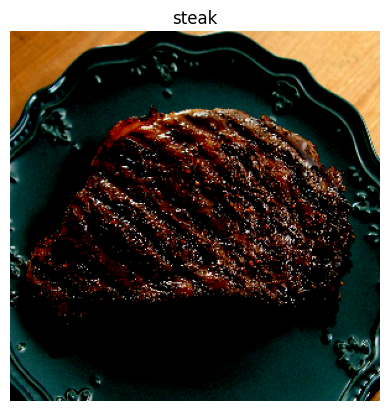

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


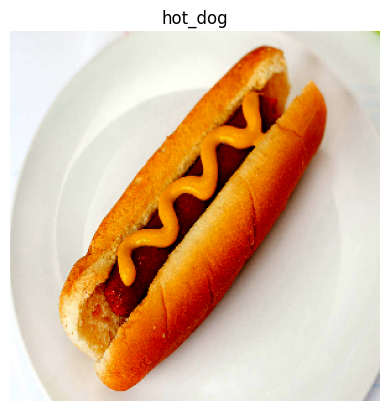

In [ ]:
images = []
images.append("test_images/" + "steak.jpeg")
images.append("test_images/" + "hotdog.jpeg")
# images.append(imagepath+'omelette.jpg')
predict_class(model_best, images, True)

## TO DO

### Class Activation map
### HEATMAP